In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_context('poster', font_scale=1.25)

We are solving

$$\frac{df}{dt}=-(\vec{v}\cdot \nabla)f + D \nabla^2 f + sf(1-f)$$

in two dimensions.

In [5]:
from adr_2d.solver import Solver

In [6]:
import skimage as ski
import skimage.io

In [7]:
sol = Solver(imax=10, jmax=10, use_morton=False, covX=3, covY=3)

Creating initial gaussian condition...
Done!
Creating advection operator...
Done!
Creating diffusion operator...
Done!


# Without morton sorting

## Logical Indices

The logical indices are basically randomly scattered; positions close in space are not necessarily close in memory.

/home/bryan/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:71: UserWarning: Non-standard image type; displaying image with stretched contrast.
  warnings.warn("Non-standard image type; displaying image with "
/home/bryan/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "
/home/bryan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


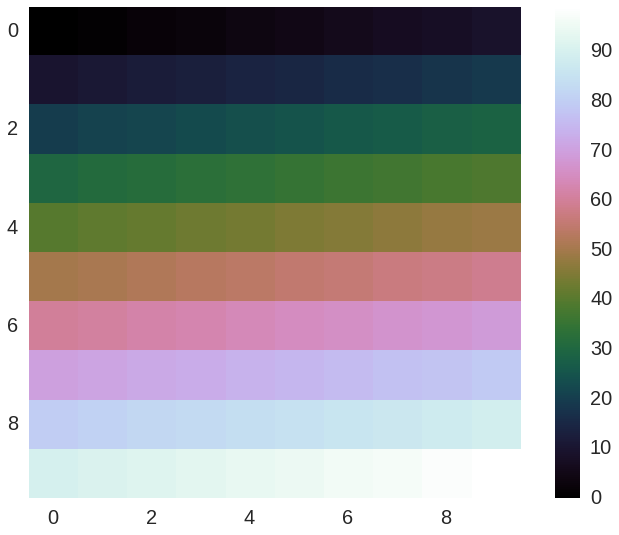

In [8]:
ski.io.imshow(sol.logical_index_mat)
plt.grid(False)

## Advection Operator

The advection operator has a beautiful structure.

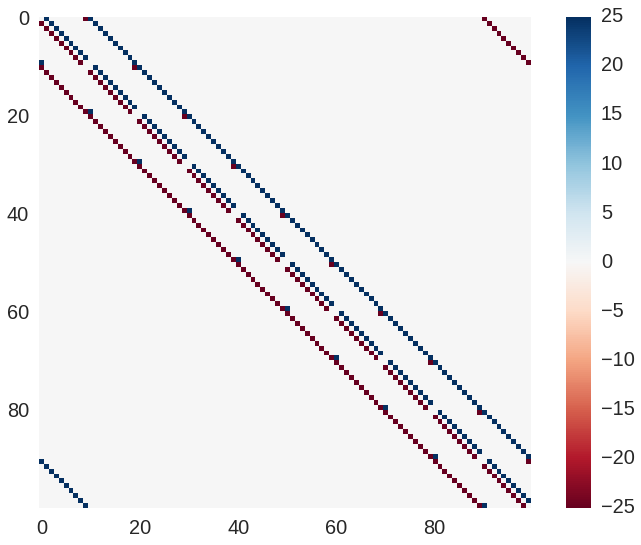

In [9]:
ski.io.imshow(sol.A.toarray())
plt.grid(False)

## Diffusion Operator

The diffusion operator has an intuitive structure, i.e. strong elements on the diagonals and weak elements everywhere else. In other words, elements in the matrix largely retain their identity but slightly transfer information to other points.

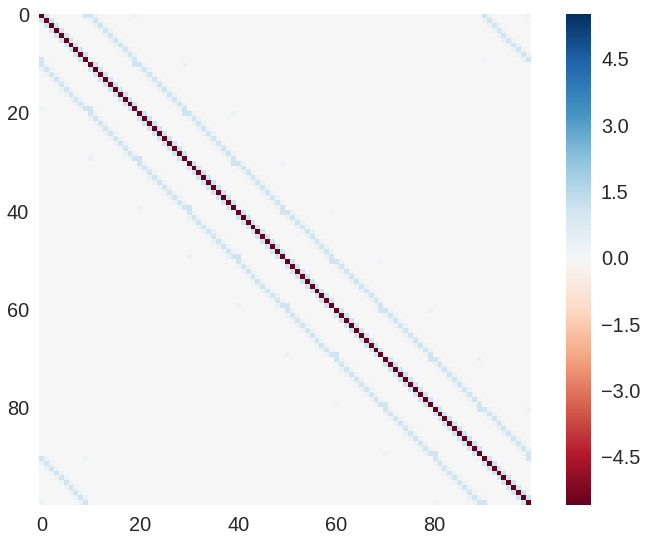

In [10]:
ski.io.imshow(sol.zeta.toarray())
plt.grid(False)

# With Morton Sorting

In [17]:
sol = Solver(imax=10, jmax=10, use_morton=True, covX=3, covY=3)

Creating initial gaussian condition...
Done!
Creating advection operator...
Done!
Creating diffusion operator...
Done!


## Logical Indices

Indices close in space are now close in memory too; this can speed up computation for large problems!

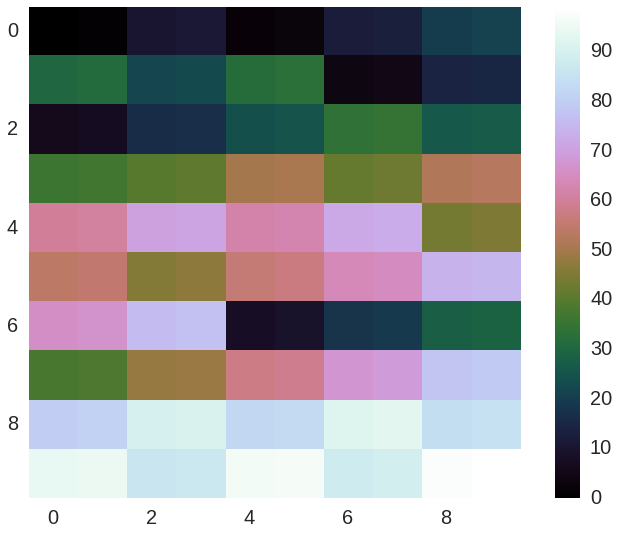

In [18]:
ski.io.imshow(sol.logical_index_mat)
plt.grid(False)

## Advection Operator

The advection operator now takes on a cool fractal shape. Our code automatically adapts to a new indexing scheme!

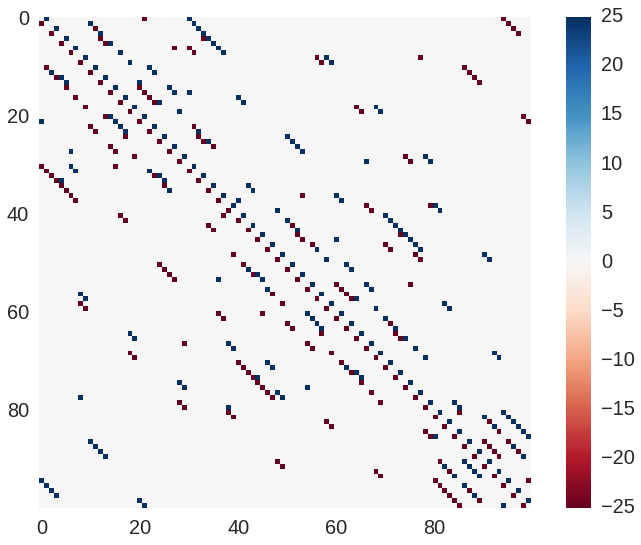

In [19]:
ski.io.imshow(sol.A.toarray())
plt.grid(False)

## Diffusion Operator

The diagonal of the diffusion operator is still strong, as expected. It is clear that elements close in space are closer together as the points diffused to are in general closer to the diagonal.

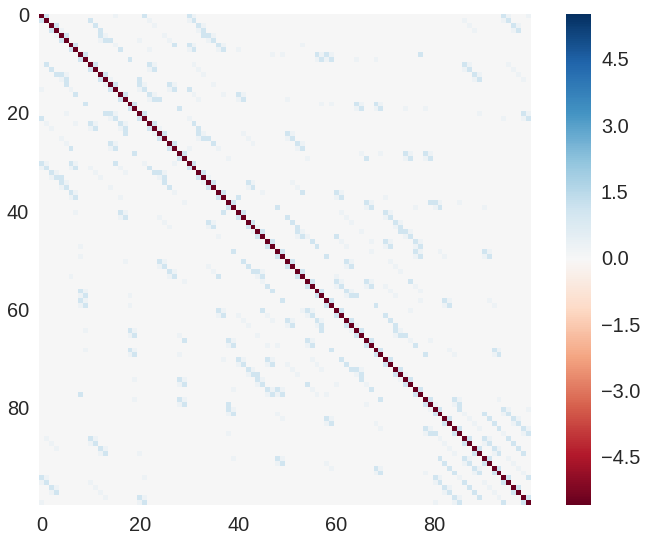

In [22]:
ski.io.imshow(sol.zeta.toarray())
plt.grid(False)